In [ ]:
#load library
import re
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint

# spacy for lemmatization
import spacy

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df = pd.read_csv("/content/drive/My Drive/crawler/IMDB Dataset.csv", )
# Remove the columns
df = df.drop(columns=['sentiment'], axis=1)
df.head()

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."


In [ ]:
# Remove punctuation
df['data_processed'] = df['review'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['data_processed'] = df['data_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['data_processed'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production <br /><br />the ...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: data_processed, dtype: object

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df.data_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', 'll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', 'br', 'br', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', 'br', 'br', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison', 'where', 'all'

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'br'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['reviewer', 'mention', 'watch', 'episode', 'hook', 'right', 'exactly', 'happen', 'first', 'thing', 'strike', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'word', 'call', 'nickname', 'give', 'state', 'focus', 'mainly', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'privacy', 'high', 'agenda', 'city', 'home', 'italian', 'irish', 'moreso', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'mess', 'first', 'episode', 'ever', 'see', 'strike', 'nasty', 'surreal', 'say', 'watch', 'developed', 'taste', 'get', 'accustomed', 'high', 'level', 'violence', 'injustice', 'crooked', 'guard', 'sell', 'nickel', 'inmate', 'kill', 'order', 'get', 'away', 'well', 'm

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 2), (33, 1), (34, 3), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 4), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 3), (98, 3), (99, 1), (100, 2), (101, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       chunksize=100,
                                       passes=10,
                                      )
pprint(lda_model.print_topics())

[(0,
  '0.020*"get" + 0.009*"car" + 0.008*"black" + 0.008*"girl" + 0.007*"guy" + '
  '0.006*"head" + 0.006*"kid" + 0.006*"school" + 0.006*"big" + 0.005*"go"'),
 (1,
  '0.024*"horror" + 0.014*"kill" + 0.010*"action" + 0.010*"scene" + '
  '0.009*"fight" + 0.009*"look" + 0.009*"blood" + 0.009*"monster" + '
  '0.008*"original" + 0.007*"evil"'),
 (2,
  '0.106*"show" + 0.033*"episode" + 0.028*"series" + 0.023*"tv" + '
  '0.015*"season" + 0.011*"cartoon" + 0.010*"animation" + 0.009*"funny" + '
  '0.009*"new" + 0.009*"television"'),
 (3,
  '0.015*"world" + 0.014*"people" + 0.010*"war" + 0.008*"documentary" + '
  '0.007*"life" + 0.007*"human" + 0.006*"soldier" + 0.006*"american" + '
  '0.006*"would" + 0.005*"live"'),
 (4,
  '0.020*"man" + 0.015*"woman" + 0.012*"go" + 0.011*"take" + 0.010*"get" + '
  '0.010*"life" + 0.010*"play" + 0.010*"find" + 0.010*"young" + '
  '0.010*"family"'),
 (5,
  '0.029*"film" + 0.023*"character" + 0.012*"seem" + 0.011*"story" + '
  '0.010*"much" + 0.010*"scene" + 0.0

In [ ]:
# Build LSA model
lsa_model = gensim.models.LsiModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       chunksize=100,
                                       )
pprint(lsa_model.print_topics())

[(0,
  '0.448*"movie" + 0.440*"film" + 0.211*"make" + 0.202*"see" + 0.163*"good" + '
  '0.136*"time" + 0.131*"character" + 0.127*"go" + 0.127*"get" + 0.115*"even"'),
 (1,
  '-0.722*"movie" + 0.674*"film" + -0.052*"bad" + -0.045*"watch" + '
  '0.026*"work" + 0.025*"man" + 0.022*"character" + 0.020*"performance" + '
  '0.019*"seem" + -0.019*"think"'),
 (2,
  '-0.547*"film" + -0.463*"movie" + 0.313*"show" + 0.182*"get" + 0.152*"go" + '
  '0.129*"character" + 0.115*"time" + 0.092*"take" + 0.090*"man" + '
  '0.089*"episode"'),
 (3,
  '0.425*"character" + -0.405*"bad" + 0.339*"story" + -0.303*"see" + '
  '-0.193*"get" + -0.155*"go" + 0.144*"play" + 0.127*"love" + -0.125*"watch" + '
  '0.110*"movie"'),
 (4,
  '0.586*"show" + 0.423*"see" + -0.294*"bad" + -0.246*"make" + -0.162*"get" + '
  '-0.140*"look" + -0.138*"scene" + 0.133*"watch" + -0.121*"even" + '
  '-0.119*"character"'),
 (5,
  '0.419*"good" + 0.405*"show" + -0.305*"see" + 0.298*"bad" + '
  '0.277*"character" + -0.198*"go" + -0.174*"m

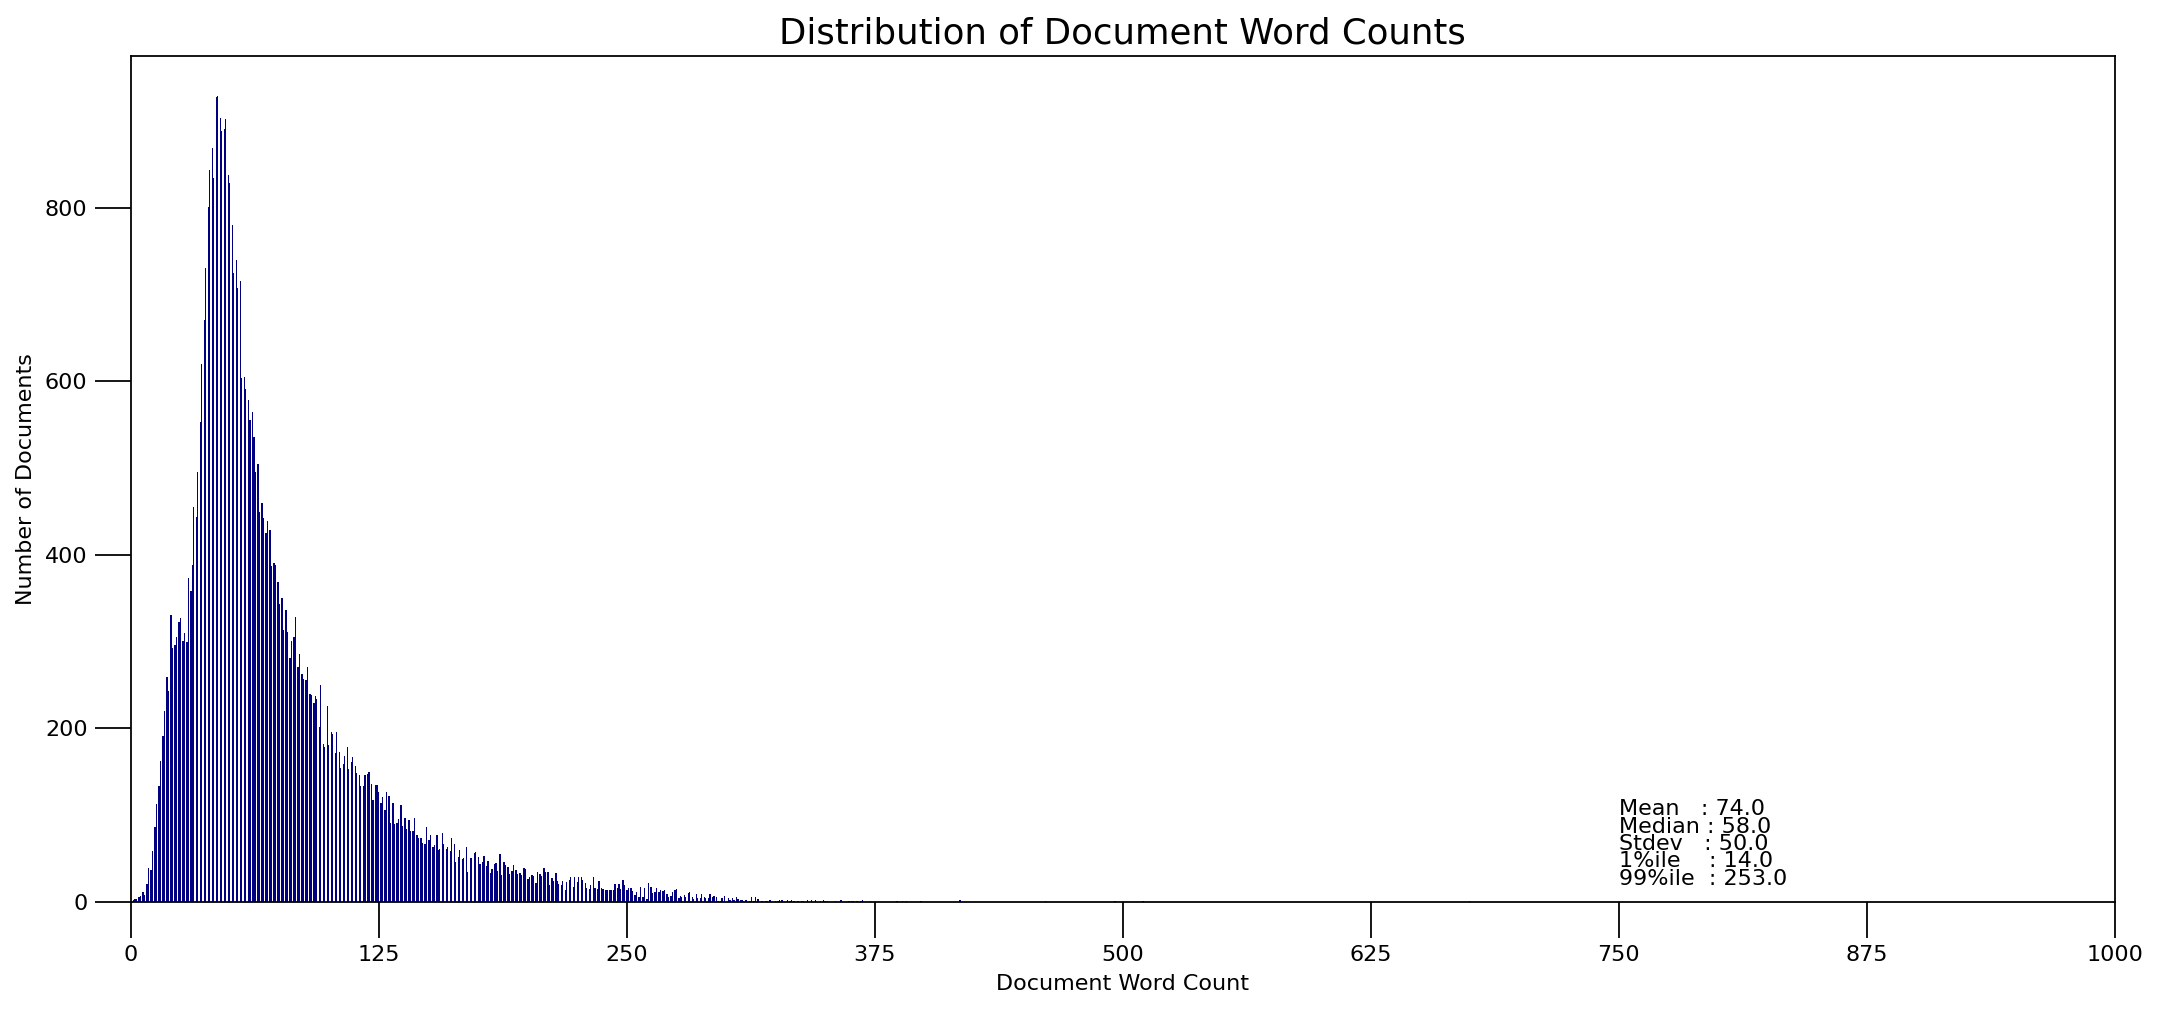

In [ ]:
doc_lens = [len(d) for d in corpus]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  80, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  60, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  40, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

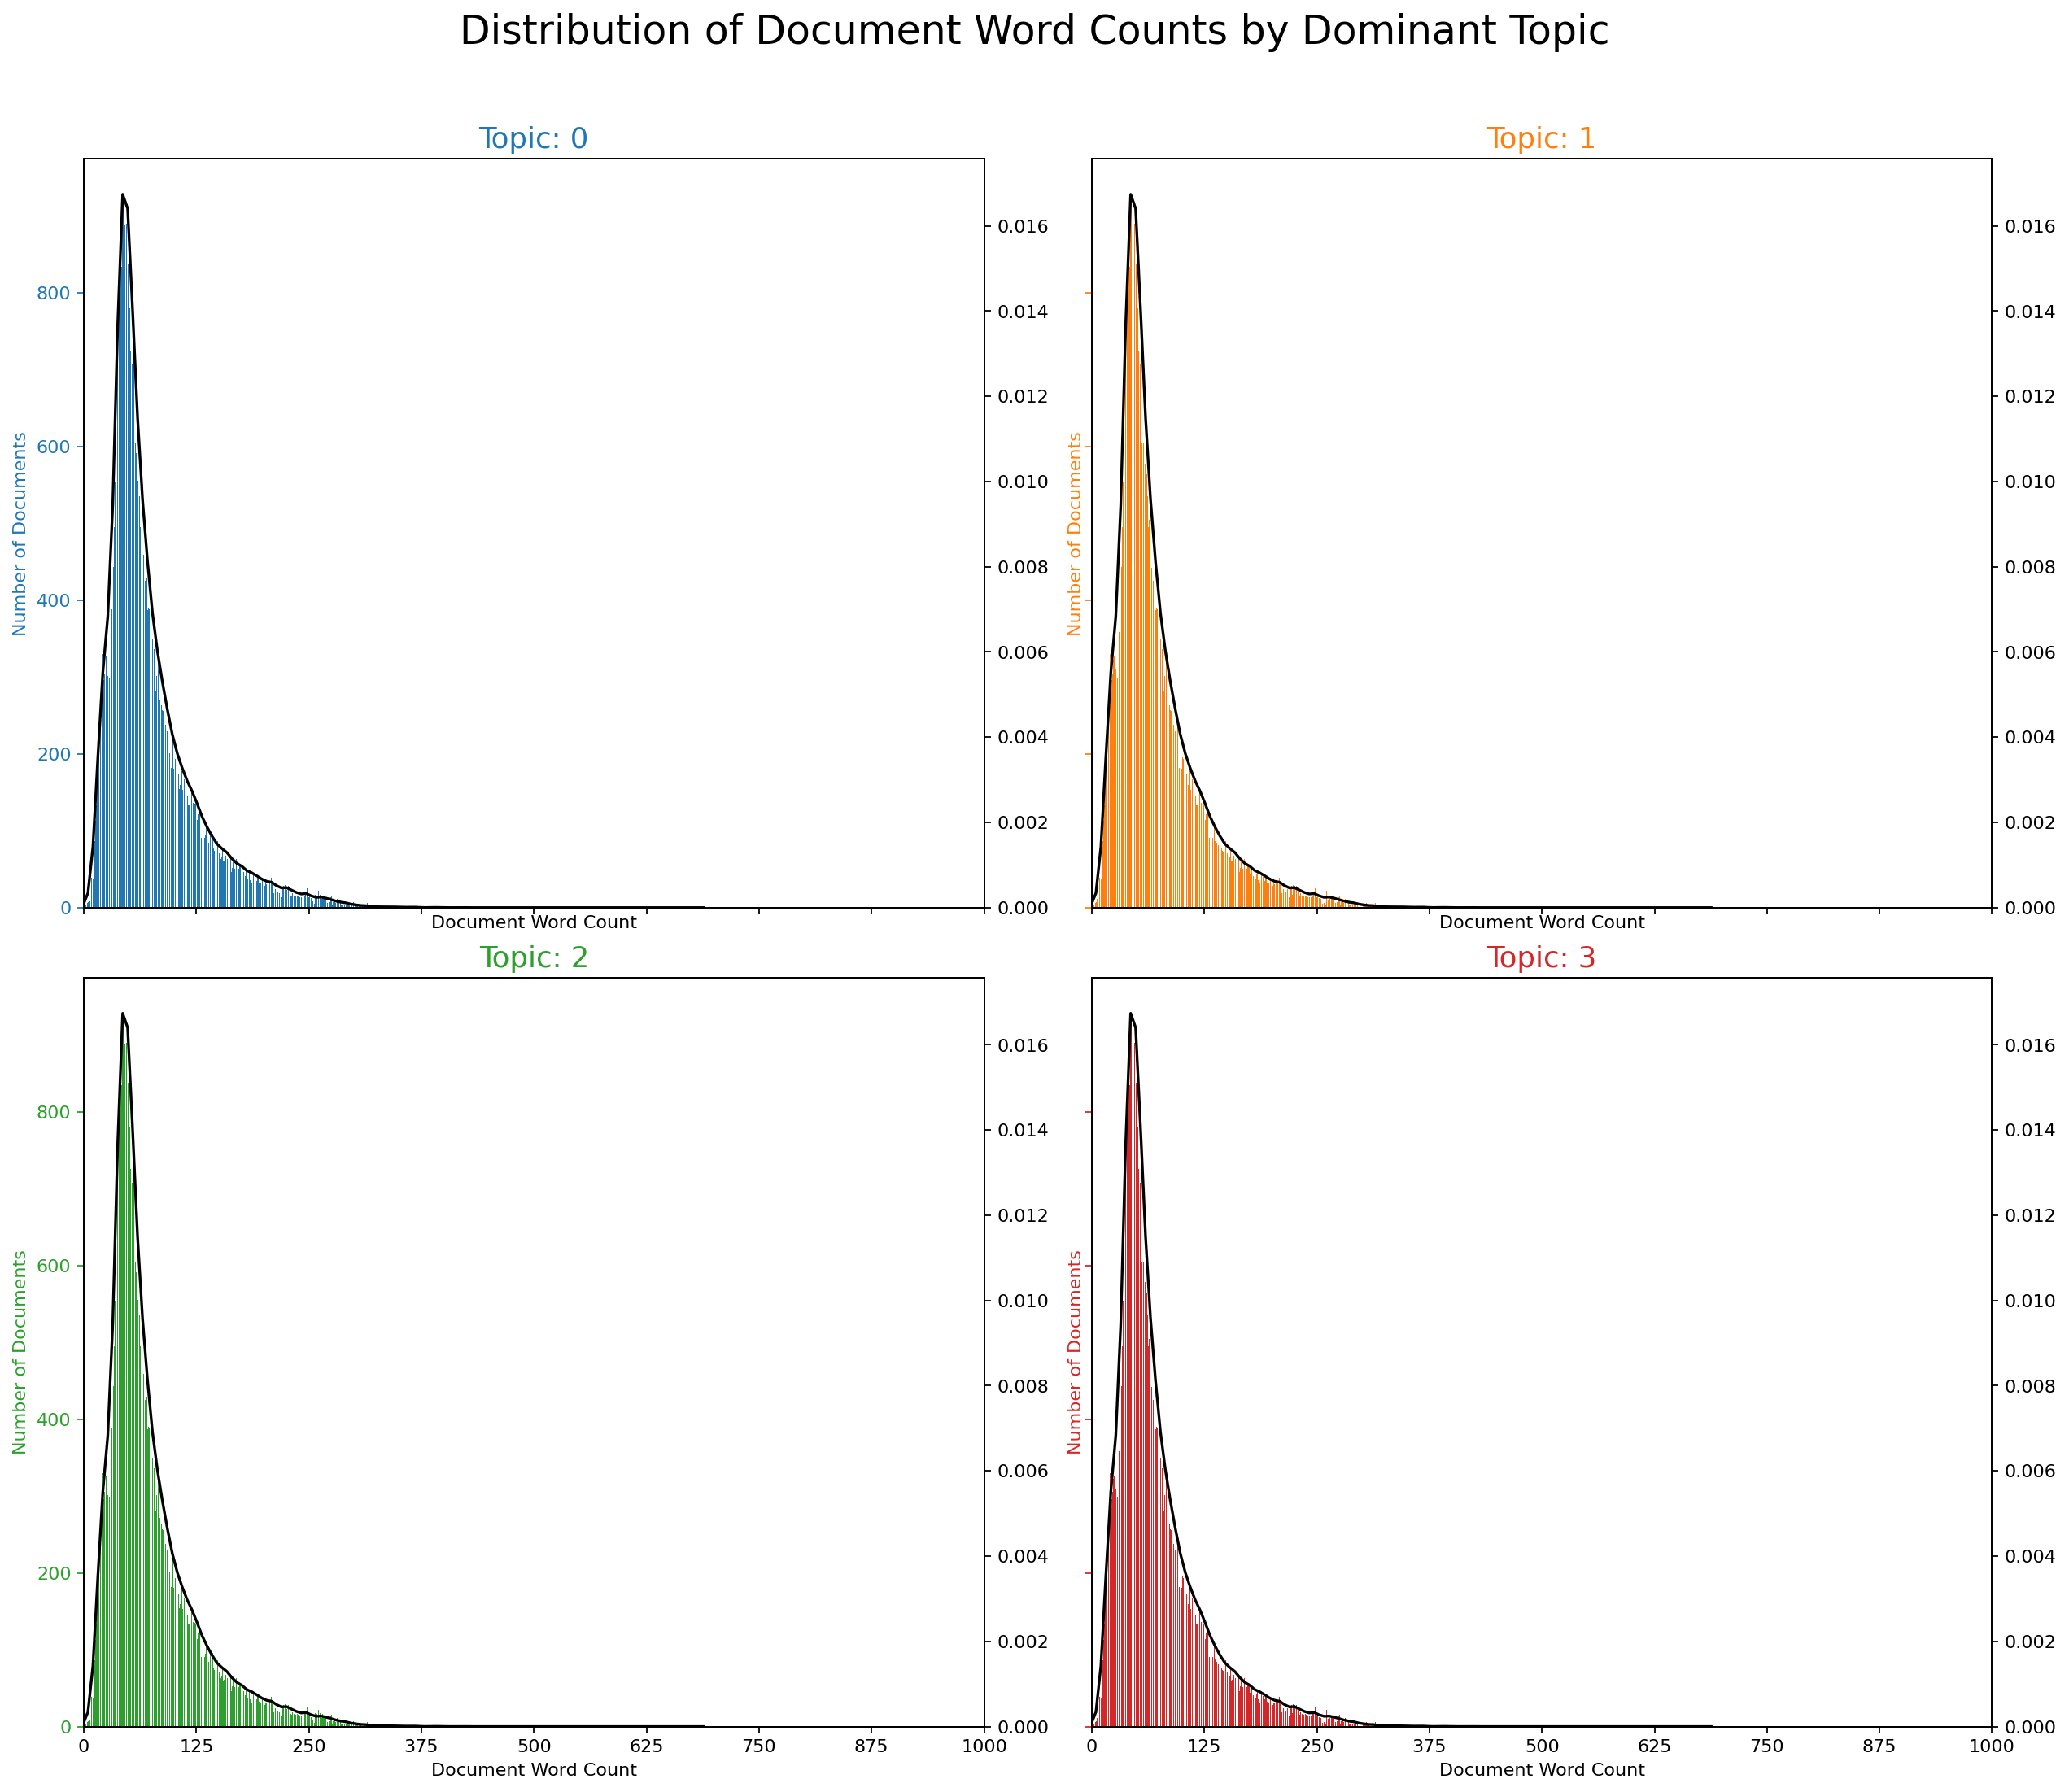

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = corpus
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()